# MTurk Analysis
## Imports and Constants

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import pprint, math, pandas.tseries

%matplotlib inline
%run -i tools/datajson.py
%config InlineBackend.figure_format = 'retina'

In [5]:
MTURK_RESP = '../private/output/mturk-resp.csv'
MTURK_Q = '../private/output/mturk-questions.txt'
REDDIT = '../private/output/2017-10-06.txt'
EXCLUDED = [63, 46, 39]
Q_LABELS = [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 22]

## Analysis

In [8]:
# Get survey results
survey_results = pd.read_csv(MTURK_RESP)
with open(MTURK_Q) as file:
    survey_questions = [line.rstrip() for line in file.readlines()]
del survey_results['Q16']
del survey_results['Q17']

# Get corresponding posts and scores
collected_posts = RedditDataJSON.from_filename(REDDIT)
raw_questions = [post['title'] for post in collected_posts.posts]
raw_scores = [int(post['score']) for post in collected_posts.posts]

for pos in EXCLUDED:
    del raw_questions[pos], raw_scores[pos]

print(ss.describe(raw_scores))
survey_results.head()

DescribeResult(nobs=97, minmax=(11, 18671), mean=942.90721649484533, variance=9523732.3350515477, skewness=4.122154184227735, kurtosis=17.11837658201545)


,1_Q1,1_Q3,1_Q4,1_Q5,1_Q6,1_Q7,1_Q8,1_Q9,1_Q10,1_Q11,...,97_Q5,97_Q6,97_Q7,97_Q8,97_Q9,97_Q10,97_Q11,97_Q12,97_Q13,97_Q22
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,4.0,5.0,3.0,3.0,4.0,2.0,2.0,5.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,5.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
ind_var = survey_results.std(axis=1, skipna=True)
ind_mean = survey_results.mean(axis=1, skipna=True)
wo_constants = survey_results.loc[ind_var > 1.5]
len(wo_constants)

168

1 0.157938203977 0.122331667214


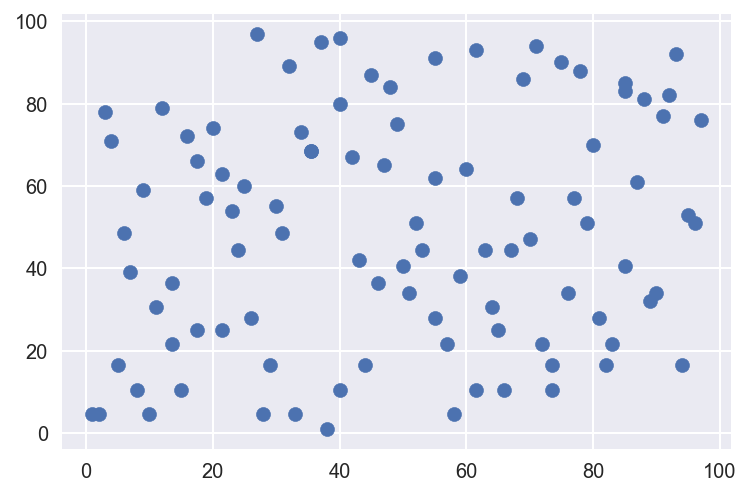

7 0.156713585772 0.125293260642


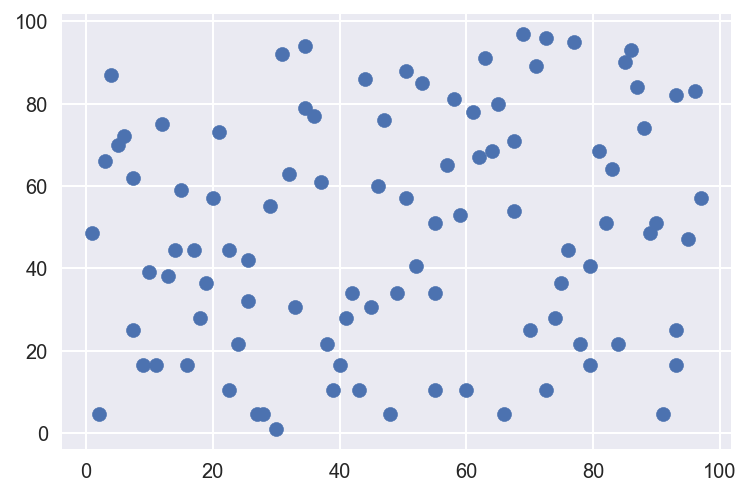

12 0.157094235182 0.124366873719


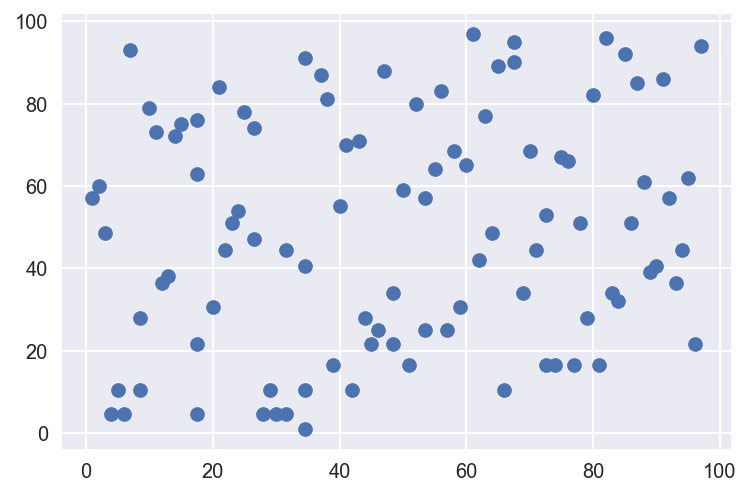

In [11]:
# Rank Correlation to Score
plot_set = []
for first in Q_LABELS:
    question_means = []
    for second in range(len(survey_questions)):
        col_label = str(second + 1) + '_Q' + str(first)
        question_means.append(wo_constants[col_label].mean())
    plot_set.append(question_means)
    
score_order = ss.rankdata(raw_scores)
for q_num, data in zip(Q_LABELS, plot_set):
    data_order = ss.rankdata(data)
    rho, pval = ss.spearmanr(data_order, score_order)
    if pval < 0.2:
        print(Q_LABELS.index(q_num) + 1, rho, pval)
        plt.scatter(data_order, score_order)
        plt.show()
        
# Question 1: Does the question itself contain information that surprises you?
# Question 7: Do you think the answer to this question is likely to have a known answer?
# Question 12: How confident are you that you know the correct answer to this question?

19


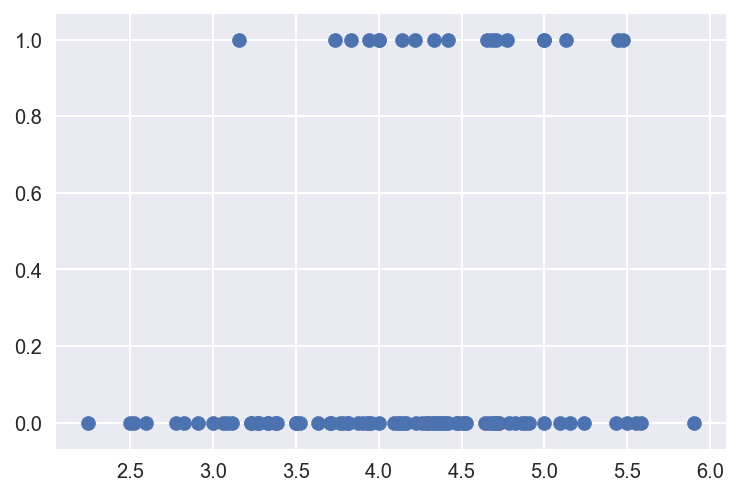

0.80412371134
0.814432989691


In [12]:
# Classification to Score
stdev = np.std(raw_scores)
mean = np.mean(raw_scores)
threshold = mean / 4
viral = [1 if score > threshold else 0 for score in raw_scores]

print(sum(viral))
plt.scatter(plot_set[0], viral)
plt.show()
    
# logistic Regression
from sklearn.linear_model import LogisticRegression
y = np.array(viral)
print(1 - y.mean())

X = pd.DataFrame(np.array(plot_set).T)
model = LogisticRegression()
model.fit(X, y)
print(model.score(X, y))
